In [59]:
"""
Requirements:
  pip install numpy pandas scikit-learn matplotlib joblib

What it does:
  - Loads 'Classification_input.csv' (first column 'label')
  - Strong baseline: SelectKBest + Elastic-Net multinomial logistic regression
  - 5-fold stratified CV with out-of-sample predictions
  - Saves:
      outputs/confusion_matrix.png
      outputs/predictions.csv
      outputs/best_model.joblib
  - Optional: Factorized decoder (Consonant 4-way × Vowel 3-way) with probability-combination
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)
from joblib import dump
import argparse


In [60]:

# -----------------------------
# 0) Paths and basic settings
# -----------------------------
CSV_PATH = "../Classification_input.csv"   # change if needed
OUT_DIR  = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)
RANDOM_STATE = 42

In [7]:
df.shape

(180, 2002)

In [61]:
# -----------------------------
# 1) Load data
# -----------------------------
df = pd.read_csv(CSV_PATH)

# Find label column robustly
label_col_candidates = [c for c in df.columns if str(c).strip().lower() == "label"]
label_col = label_col_candidates[0] if label_col_candidates else df.columns[0]

y_raw = df[label_col].values
X_df  = df.drop(columns=[label_col])

# Encode labels to 0..K-1 (keep original names)
y_cat = pd.Categorical(y_raw)
y     = y_cat.codes
class_names = list(map(str, y_cat.categories))

# Coerce features to numeric (NaNs are imputed later)
X_df = X_df.apply(pd.to_numeric, errors="coerce")
X    = X_df.values

n_samples, n_features = X.shape
n_classes = len(class_names)

print(f"Data: {n_samples} samples, {n_features} features, {n_classes} classes")
print("Label mapping (id -> original):")
print({i: class_names[i] for i in range(n_classes)})

# Class balance (just to eyeball)
counts = pd.Series(y).value_counts().sort_index()
print("\nClass counts per label:")
print(pd.DataFrame({"id": range(n_classes), "label": class_names, "count": counts.values}))


Data: 180 samples, 2001 features, 12 classes
Label mapping (id -> original):
{0: 'ghah', 1: 'ghee', 2: 'ghoo', 3: 'sah', 4: 'see', 5: 'soo', 6: 'tah', 7: 'tee', 8: 'too', 9: 'vah', 10: 'vee', 11: 'voo'}

Class counts per label:
    id label  count
0    0  ghah     15
1    1  ghee     15
2    2  ghoo     15
3    3   sah     15
4    4   see     15
5    5   soo     15
6    6   tah     15
7    7   tee     15
8    8   too     15
9    9   vah     15
10  10   vee     15
11  11   voo     15



=== Baseline (12-way) | 5-fold out-of-sample performance ===
Accuracy:          0.411
Balanced accuracy: 0.411
F1 macro:          0.407

Per-class report:
              precision    recall  f1-score   support

        ghah      0.600     0.600     0.600        15
        ghee      0.500     0.667     0.571        15
        ghoo      0.350     0.467     0.400        15
         sah      0.357     0.333     0.345        15
         see      0.312     0.333     0.323        15
         soo      0.417     0.333     0.370        15
         tah      0.231     0.200     0.214        15
         tee      0.333     0.400     0.364        15
         too      0.538     0.467     0.500        15
         vah      0.455     0.333     0.385        15
         vee      0.333     0.267     0.296        15
         voo      0.500     0.533     0.516        15

    accuracy                          0.411       180
   macro avg      0.411     0.411     0.407       180
weighted avg      0.411     0.41

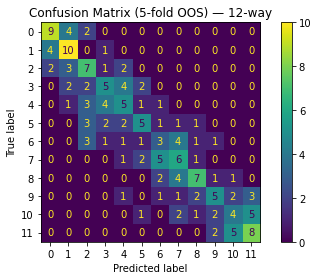

In [62]:
# -----------------------------
# 2) Strong baseline decoder
# -----------------------------
# Why this works well here:
# - Impute missing values (median) -> robust to NaNs
# - Standardize -> needed for linear models and ANOVA scores
# - SelectKBest(f_classif) -> reduce dimension to the most discriminative time bins
# - Elastic-Net multinomial logistic -> strong, sparse-ish, handles correlated features
#
# NOTE: k_keep=200 is a good starting point for ~2k features and ~180 samples.
#       You can try 100 or 300 if you want to tune—it trades bias/variance.
k_keep = min(200, n_features)

pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("select", SelectKBest(score_func=f_classif, k=k_keep)),
    ("clf", LogisticRegression(
        solver="saga",
        penalty="elasticnet",
        multi_class="multinomial",
        max_iter=4000,
        C=1.0,           # reasonable default
        l1_ratio=0.5,    # mix of L1/L2
        random_state=RANDOM_STATE
    ))
])

# Out-of-sample predictions via 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
y_pred_oos = cross_val_predict(pipe, X, y, cv=cv, method="predict", n_jobs=-1)

acc  = accuracy_score(y, y_pred_oos)
bacc = balanced_accuracy_score(y, y_pred_oos)
f1m  = f1_score(y, y_pred_oos, average="macro")

print("\n=== Baseline (12-way) | 5-fold out-of-sample performance ===")
print(f"Accuracy:          {acc:.3f}")
print(f"Balanced accuracy: {bacc:.3f}")
print(f"F1 macro:          {f1m:.3f}")
print("\nPer-class report:")
print(classification_report(y, y_pred_oos, target_names=class_names, digits=3, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y, y_pred_oos)
fig = plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(n_classes)])
disp.plot(values_format='d')
plt.title("Confusion Matrix (5-fold OOS) — 12-way")
plt.tight_layout()
cm_path = os.path.join(OUT_DIR, "confusion_matrix_12way.png")
plt.savefig(cm_path, dpi=150)
plt.close(fig)
print(f"Saved confusion matrix → {cm_path}")

In [63]:
# Fit on full data and save model
pipe.fit(X, y)
model_path = os.path.join(OUT_DIR, "best_model_12way.joblib")
dump(pipe, model_path)
print(f"Saved fitted model → {model_path}")

# Save OOS predictions
pred_path = os.path.join(OUT_DIR, "predictions_12way.csv")
pd.DataFrame({
    "true_id": y,
    "true_label": [class_names[i] for i in y],
    "pred_id": y_pred_oos,
    "pred_label": [class_names[i] for i in y_pred_oos]
}).to_csv(pred_path, index=False)
print(f"Saved OOS predictions → {pred_path}")

Saved fitted model → outputs/best_model_12way.joblib
Saved OOS predictions → outputs/predictions_12way.csv



Detected consonants (4): {0: 'g', 1: 's', 2: 't', 3: 'v'}
Detected vowels     ({nV}): {0: 'ah', 1: 'ee', 2: 'oo'}

=== Factorized (C×V) | 5-fold out-of-sample performance ===
Accuracy:          0.378
Balanced accuracy: 0.378
F1 macro:          0.368
Saved factorized confusion matrix → outputs/confusion_matrix_CxV.png

=== Ensemble (12-way + C×V) | 5-fold OOS ===
Accuracy:          0.394
Balanced accuracy: 0.394
F1 macro:          0.384

Wrote summary → outputs/summary.txt


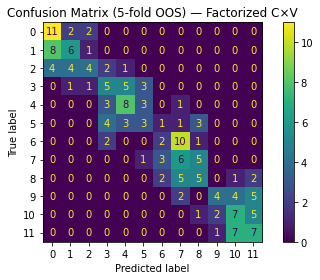

In [64]:
# -----------------------------
# 3) (Optional) Factorized decoder: C×V
# -----------------------------
# If each unit tends to encode *either* consonant or vowel, a flat 12-way model
# can struggle. A common trick: decode consonant (4-way) and vowel (3-way)
# separately, then combine probabilities: P(CV)=P(C)*P(V).
#
# We'll derive C and V from your label strings:
#   consonant = first character (g/s/t/v)
#   vowel     = last two letters (ah/ee/oo)
# Adjust the parsing if your labels change.
def split_cv_labels(names):
    cons_map = {}
    vow_map  = {}
    yC = []
    yV = []
    for name in names:
        # Conservative parsing
        c = name[0].lower()
        v = name[-2:].lower()
        if c not in cons_map:
            cons_map[c] = len(cons_map)
        if v not in vow_map:
            vow_map[v] = len(vow_map)
        yC.append(cons_map[c])
        yV.append(vow_map[v])
    inv_cons = {v:k for k,v in cons_map.items()}
    inv_vow  = {v:k for k,v in vow_map.items()}
    return np.array(yC), np.array(yV), inv_cons, inv_vow

yC, yV, inv_cons, inv_vow = split_cv_labels(class_names)
nC, nV = len(inv_cons), len(inv_vow)
print(f"\nDetected consonants ({nC}):", inv_cons)
print("Detected vowels     ({nV}):", inv_vow)

# Expand trial-wise C/V targets from the class id y
y_trial_C = yC[y]  # map each trial's class id to its consonant id
y_trial_V = yV[y]  # map to vowel id

# Two separate models (same pipeline shape), get OOS probabilities
def oos_proba(pipe, X, y, cv):
    # cross_val_predict with method='predict_proba' works for LogisticRegression
    return cross_val_predict(pipe, X, y, cv=cv, method="predict_proba", n_jobs=-1)

pipe_C = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("select", SelectKBest(score_func=f_classif, k=k_keep)),
    ("clf", LogisticRegression(
        solver="saga", penalty="elasticnet", multi_class="multinomial",
        max_iter=4000, C=1.0, l1_ratio=0.5, random_state=RANDOM_STATE))
])

pipe_V = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("select", SelectKBest(score_func=f_classif, k=k_keep)),
    ("clf", LogisticRegression(
        solver="saga", penalty="elasticnet", multi_class="multinomial",
        max_iter=4000, C=1.0, l1_ratio=0.5, random_state=RANDOM_STATE))
])

pC = oos_proba(pipe_C, X, y_trial_C, cv)
pV = oos_proba(pipe_V, X, y_trial_V, cv)

# Combine probs under independence: P(CV)=P(C)*P(V)
pCV = np.einsum('ij,ik->ijk', pC, pV).reshape(len(X), nC*nV)
y_pred_fac = pCV.argmax(axis=1)

acc_fac  = accuracy_score(y, y_pred_fac)
bacc_fac = balanced_accuracy_score(y, y_pred_fac)
f1m_fac  = f1_score(y, y_pred_fac, average="macro")

print("\n=== Factorized (C×V) | 5-fold out-of-sample performance ===")
print(f"Accuracy:          {acc_fac:.3f}")
print(f"Balanced accuracy: {bacc_fac:.3f}")
print(f"F1 macro:          {f1m_fac:.3f}")

cm_fac = confusion_matrix(y, y_pred_fac)
fig = plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay(confusion_matrix=cm_fac, display_labels=[str(i) for i in range(n_classes)]).plot(values_format='d')
plt.title("Confusion Matrix (5-fold OOS) — Factorized C×V")
plt.tight_layout()
cm_fac_path = os.path.join(OUT_DIR, "confusion_matrix_CxV.png")
plt.savefig(cm_fac_path, dpi=150)
plt.close(fig)
print(f"Saved factorized confusion matrix → {cm_fac_path}")

# Optional: simple ensemble of the two approaches (average probabilities)
# For that, also get baseline 12-way probabilities:
pipe_prob12 = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("select", SelectKBest(score_func=f_classif, k=k_keep)),
    ("clf", LogisticRegression(
        solver="saga", penalty="elasticnet", multi_class="multinomial",
        max_iter=4000, C=1.0, l1_ratio=0.5, random_state=RANDOM_STATE))
])
p12 = cross_val_predict(pipe_prob12, X, y, cv=cv, method="predict_proba", n_jobs=-1)

# Ensemble: average 12-way probs with factorized probs
p_ens = 0.5 * p12 + 0.5 * pCV
y_pred_ens = p_ens.argmax(axis=1)
acc_ens  = accuracy_score(y, y_pred_ens)
bacc_ens = balanced_accuracy_score(y, y_pred_ens)
f1m_ens  = f1_score(y, y_pred_ens, average="macro")

print("\n=== Ensemble (12-way + C×V) | 5-fold OOS ===")
print(f"Accuracy:          {acc_ens:.3f}")
print(f"Balanced accuracy: {bacc_ens:.3f}")
print(f"F1 macro:          {f1m_ens:.3f}")

# Save final comparison
with open(os.path.join(OUT_DIR, "summary.txt"), "w") as f:
    f.write("Baseline 12-way:\n")
    f.write(f"  Acc={acc:.3f}, BAcc={bacc:.3f}, F1m={f1m:.3f}\n")
    f.write("Factorized C×V:\n")
    f.write(f"  Acc={acc_fac:.3f}, BAcc={bacc_fac:.3f}, F1m={f1m_fac:.3f}\n")
    f.write("Ensemble (avg probs):\n")
    f.write(f"  Acc={acc_ens:.3f}, BAcc={bacc_ens:.3f}, F1m={f1m_ens:.3f}\n")

print(f"\nWrote summary → {os.path.join(OUT_DIR, 'summary.txt')}")

In [8]:
"""
Per-unit classification with Elastic-Net multinomial logistic regression (12-way)
and a factorized consonant×vowel decoder.

- Assumes the CSV's first column named 'label' (Y), and the rest are X.
- Each unit contributes exactly 200 consecutive feature columns.
- If an extra 'Unnamed: 0' column exists, it will be dropped automatically.

Outputs (in --outdir):
  - per_unit_accuracies.csv
  - per_unit_fold_accuracies.csv
  - unit_accuracy_comparison.png

Usage:
  python per_unit_decoder.py --csv Classification_input.csv \
      --outdir outputs --k_keep 150 --splits 5 --C 1.0 --l1 0.5 --max_iter 3000

Notes:
- k_keep is the number of features kept by SelectKBest for each unit (<= 200).
- Factorized decoding derives consonant as first letter and vowel as last two
  letters from the label strings (e.g., "ghah" -> c='g', v='ah').
"""

'\nPer-unit classification with Elastic-Net multinomial logistic regression (12-way)\nand a factorized consonant×vowel decoder.\n\n- Assumes the CSV\'s first column named \'label\' (Y), and the rest are X.\n- Each unit contributes exactly 200 consecutive feature columns.\n- If an extra \'Unnamed: 0\' column exists, it will be dropped automatically.\n\nOutputs (in --outdir):\n  - per_unit_accuracies.csv\n  - per_unit_fold_accuracies.csv\n  - unit_accuracy_comparison.png\n\nUsage:\n  python per_unit_decoder.py --csv Classification_input.csv       --outdir outputs --k_keep 150 --splits 5 --C 1.0 --l1 0.5 --max_iter 3000\n\nNotes:\n- k_keep is the number of features kept by SelectKBest for each unit (<= 200).\n- Factorized decoding derives consonant as first letter and vowel as last two\n  letters from the label strings (e.g., "ghah" -> c=\'g\', v=\'ah\').\n'

In [29]:

def parse_args():
    ap = argparse.ArgumentParser()
    ap.add_argument("--csv", type=str, default=CSV_PATH, help="Path to input CSV")
    ap.add_argument("--outdir", type=str, default="outputs", help="Output directory")
    ap.add_argument("--splits", type=int, default=5, help="Stratified K-fold splits")
    ap.add_argument("--k_keep", type=int, default=150, help="SelectKBest features per unit (<=200)")
    ap.add_argument("--C", type=float, default=1.0, help="LogReg regularization strength (C)")
    ap.add_argument("--l1", type=float, default=0.5, help="Elastic-net l1_ratio [0..1]")
    ap.add_argument("--max_iter", type=int, default=3000, help="Max iterations for LogReg")
    ap.add_argument("--tol", type=float, default=1e-3, help="Tolerance for LogReg convergence")
    ap.add_argument("--random_state", type=int, default=42, help="Random seed")
    ap.add_argument('-f')

    return ap.parse_args()

def load_data(csv_path):
    df = pd.read_csv(csv_path)

    # Label column
    label_cols = [c for c in df.columns if str(c).strip().lower() == "label"]
    label_col = label_cols[0] if label_cols else df.columns[0]

    y_raw = df[label_col].values
    X_df = df.drop(columns=[label_col])

    # Drop any 'Unnamed:*' columns
    extra_cols = [c for c in X_df.columns if str(c).lower().startswith("unnamed")]
    if extra_cols:
        X_df = X_df.drop(columns=extra_cols)

    # Coerce to numeric
    X_df = X_df.apply(pd.to_numeric, errors="coerce")
    X = X_df.values

    # Encode labels 0..K-1
    y_cat = pd.Categorical(y_raw)
    y = y_cat.codes
    class_names = list(map(str, y_cat.categories))
    return X, y, class_names

def ensure_unit_layout(X, features_per_unit=200):
    n_features = X.shape[1]
    if n_features % features_per_unit != 0:
        raise ValueError(
            f"Expected feature columns to be a multiple of {features_per_unit}, "
            f"but got {n_features}. Check your CSV (or drop extra columns)."
        )
    n_units = n_features // features_per_unit
    return n_units

def make_pipe(k_keep, C, l1_ratio, max_iter, tol, random_state):
    return Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("select", SelectKBest(score_func=f_classif, k=k_keep)),
        ("clf", LogisticRegression(
            solver="saga",
            penalty="elasticnet",
            multi_class="multinomial",
            C=C,
            l1_ratio=l1_ratio,
            max_iter=max_iter,
            tol=tol,
            random_state=random_state
        ))
    ])

def split_cv_labels(class_names):
    """
    Parse consonant as first character, vowel as last two letters.
    Returns:
      yC_from_class: length-K array mapping class_id -> consonant_id
      yV_from_class: length-K array mapping class_id -> vowel_id
      inv_cons, inv_vow: id->string maps
    """
    cons_map, vow_map = {}, {}
    yC_ids, yV_ids = [], []
    for name in class_names:
        c = name[0].lower()
        v = name[-2:].lower()
        if c not in cons_map:
            cons_map[c] = len(cons_map)
        if v not in vow_map:
            vow_map[v] = len(vow_map)
        yC_ids.append(cons_map[c])
        yV_ids.append(vow_map[v])

    inv_cons = {v: k for k, v in cons_map.items()}
    inv_vow  = {v: k for k, v in vow_map.items()}
    return np.array(yC_ids), np.array(yV_ids), inv_cons, inv_vow

def evaluate_unit(
    X_unit, y, splits, yC_from_class, yV_from_class, pair_to_class,
    k_keep, C, l1_ratio, max_iter, tol, random_state
):
    """
    Returns per-fold accuracies:
      fold_acc_12:  12-way accuracies per fold
      fold_acc_CV:  factorized C×V accuracies per fold
    """
    k_eff = min(k_keep, X_unit.shape[1])

    pipe12 = make_pipe(k_eff, C, l1_ratio, max_iter, tol, random_state)
    pipeC  = make_pipe(k_eff, C, l1_ratio, max_iter, tol, random_state)
    pipeV  = make_pipe(k_eff, C, l1_ratio, max_iter, tol, random_state)

    yC = yC_from_class[y]
    yV = yV_from_class[y]

    fold_acc_12, fold_acc_CV = [], []

    for tr_idx, te_idx in splits:
        Xtr, Xte = X_unit[tr_idx], X_unit[te_idx]
        ytr, yte = y[tr_idx], y[te_idx]

        # 12-way
        pipe12.fit(Xtr, ytr)
        yhat12 = pipe12.predict(Xte)
        fold_acc_12.append(accuracy_score(yte, yhat12))

        # Factorized: fit C- and V-heads
        pipeC.fit(Xtr, yC[tr_idx])
        pipeV.fit(Xtr, yV[tr_idx])

        pC_raw = pipeC.predict_proba(Xte)
        pV_raw = pipeV.predict_proba(Xte)

        # Align to fixed class index sets [0..nC-1] and [0..nV-1]
        nC = len(np.unique(yC))
        nV = len(np.unique(yV))
        pC = np.zeros((len(te_idx), nC))
        pV = np.zeros((len(te_idx), nV))

        for j, c_id in enumerate(pipeC.named_steps["clf"].classes_):
            pC[:, int(c_id)] = pC_raw[:, j]
        for j, v_id in enumerate(pipeV.named_steps["clf"].classes_):
            pV[:, int(v_id)] = pV_raw[:, j]

        # Combine probabilities per test sample: P(CV) = P(C)*P(V)
        yhat_fac = np.empty(len(te_idx), dtype=int)
        for i_row in range(len(te_idx)):
            M = np.outer(pC[i_row], pV[i_row])  # (nC, nV)
            c_hat, v_hat = np.unravel_index(np.argmax(M), M.shape)
            yhat_fac[i_row] = pair_to_class[(int(c_hat), int(v_hat))]

        fold_acc_CV.append(accuracy_score(yte, yhat_fac))

    return np.array(fold_acc_12), np.array(fold_acc_CV)

In [32]:
args = parse_args()
os.makedirs(args.outdir, exist_ok=True)
args.csv = CSV_PATH

print(f"Loading: {args.csv}")
X, y, class_names = load_data(args.csv)
n_samples, n_features = X.shape
print(f"Data: {n_samples} samples, {n_features} features, {len(class_names)} classes")

n_units = ensure_unit_layout(X, features_per_unit=200)
print(f"Detected {n_units} units (200 features each).")

# Build maps for factorized decoding
yC_from_class, yV_from_class, inv_cons, inv_vow = split_cv_labels(class_names)
pair_to_class = {(yC_from_class[i], yV_from_class[i]): i for i in range(len(class_names))}

# CV splits (shared across units)
skf = StratifiedKFold(n_splits=args.splits, shuffle=True, random_state=args.random_state)
splits = list(skf.split(X, y))

per_unit_rows = []
per_unit_fold_rows = []

for unit_idx in range(n_units):
    s, e = unit_idx * 200, (unit_idx + 1) * 200
    X_unit = X[:, s:e]
    print(f"\nUnit {unit_idx+1}: evaluating on features [{s}:{e})")

    fold_acc_12, fold_acc_CV = evaluate_unit(
        X_unit, y, splits,
        yC_from_class, yV_from_class, pair_to_class,
        args.k_keep, args.C, args.l1, args.max_iter, args.tol, args.random_state
    )

    per_unit_rows.append({
        "unit": unit_idx + 1,
        "acc_12way_mean": float(fold_acc_12.mean()),
        "acc_12way_std": float(fold_acc_12.std(ddof=1)),
        "acc_CxV_mean": float(fold_acc_CV.mean()),
        "acc_CxV_std": float(fold_acc_CV.std(ddof=1)),
    })

    for f_idx, (a12, aCV) in enumerate(zip(fold_acc_12, fold_acc_CV), start=1):
        per_unit_fold_rows.append({
            "unit": unit_idx + 1,
            "fold": f_idx,
            "acc_12way": float(a12),
            "acc_CxV": float(aCV),
        })

per_unit_df = pd.DataFrame(per_unit_rows)
per_unit_fold_df = pd.DataFrame(per_unit_fold_rows)

per_unit_csv = os.path.join(args.outdir, "per_unit_accuracies.csv")
per_unit_fold_csv = os.path.join(args.outdir, "per_unit_fold_accuracies.csv")
per_unit_df.to_csv(per_unit_csv, index=False)
per_unit_fold_df.to_csv(per_unit_fold_csv, index=False)
print("\nSaved per-unit summary →", per_unit_csv)
print("Saved per-unit per-fold →", per_unit_fold_csv)

Loading: ../Classification_input.csv
Data: 180 samples, 2000 features, 12 classes
Detected 10 units (200 features each).

Unit 1: evaluating on features [0:200)

Unit 2: evaluating on features [200:400)

Unit 3: evaluating on features [400:600)

Unit 4: evaluating on features [600:800)

Unit 5: evaluating on features [800:1000)

Unit 6: evaluating on features [1000:1200)

Unit 7: evaluating on features [1200:1400)

Unit 8: evaluating on features [1400:1600)

Unit 9: evaluating on features [1600:1800)

Unit 10: evaluating on features [1800:2000)

Saved per-unit summary → outputs/per_unit_accuracies.csv
Saved per-unit per-fold → outputs/per_unit_fold_accuracies.csv


In [34]:
means_12

array([0.07777778, 0.07222222, 0.09444444, 0.14444444, 0.12222222,
       0.06666667, 0.09444444, 0.12777778, 0.07777778, 0.07222222])

Saved figure → outputs/unit_accuracy_comparison.png


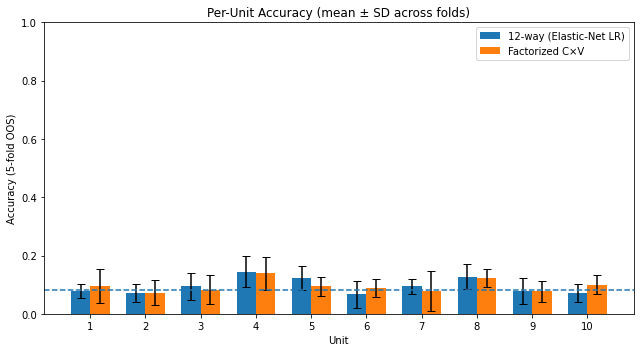

In [33]:
# ------------------------ Plot ------------------------
units = per_unit_df["unit"].values
means_12 = per_unit_df["acc_12way_mean"].values
stds_12  = per_unit_df["acc_12way_std"].values
means_CV = per_unit_df["acc_CxV_mean"].values
stds_CV  = per_unit_df["acc_CxV_std"].values

x = np.arange(len(units))
width = 0.35

fig = plt.figure(figsize=(9, 5))
ax = plt.gca()
ax.bar(x - width/2, means_12, width, yerr=stds_12, capsize=4, label="12-way (Elastic-Net LR)")
ax.bar(x + width/2, means_CV, width, yerr=stds_CV, capsize=4, label="Factorized C×V")

ax.set_xticks(x)
ax.set_xticklabels([str(u) for u in units])
ax.set_xlabel("Unit")
ax.set_ylabel("Accuracy (5-fold OOS)")
ax.set_title("Per-Unit Accuracy (mean ± SD across folds)")
ax.set_ylim(0.0, 1.0)
# Chance line for 12 classes
ax.axhline(1.0 / len(class_names), linestyle="--")
ax.legend()

plt.tight_layout()
plot_path = os.path.join(args.outdir, "unit_accuracy_comparison.png")
#plt.savefig(plot_path, dpi=150)
#plt.close(fig)
print("Saved figure →", plot_path);

In [36]:
# ---------------- User settings ----------------
CSV_PATH = "../Classification_input.csv"  # change if needed
FEATURES_PER_UNIT = 200
N_SPLITS = 5
RANDOM_STATE = 42

In [37]:
# Keep k smallish for speed; you can increase if you like
K_KEEP_UNIT = 80        # features to keep per unit (<= 200)
K_KEEP_COMBINED = 300   # features to keep when combining all units (<= total features)

# Elastic-Net LR hyperparams
C = 0.5
L1_RATIO = 0.5
MAX_ITER = 2000
TOL = 1e-3

# Output (saves a PNG next to your notebook)
FIGURE_PATH = "unit_accuracy_comparison_with_combined.png"

# ---------------- Load & prep data ----------------
df = pd.read_csv(CSV_PATH)

# Find label column robustly
label_cols = [c for c in df.columns if str(c).strip().lower() == "label"]
label_col = label_cols[0] if label_cols else df.columns[0]

y_raw = df[label_col].values
X_df = df.drop(columns=[label_col])

# Drop "Unnamed:*" index columns if present
extra_cols = [c for c in X_df.columns if str(c).lower().startswith("unnamed")]
if extra_cols:
    X_df = X_df.drop(columns=extra_cols)

# Coerce to numeric
X_df = X_df.apply(pd.to_numeric, errors="coerce")

# If feature count isn't a multiple of 200, trim extra trailing columns
if X_df.shape[1] % FEATURES_PER_UNIT != 0:
    new_cols = (X_df.shape[1] // FEATURES_PER_UNIT) * FEATURES_PER_UNIT
    print(f"[Note] Trimming feature columns from {X_df.shape[1]} to {new_cols} to match {FEATURES_PER_UNIT}-per-unit layout.")
    X_df = X_df.iloc[:, :new_cols]

X_all = X_df.values
n_samples, n_features = X_all.shape
n_units = n_features // FEATURES_PER_UNIT

# Encode labels to 0..K-1, keep names
y_cat = pd.Categorical(y_raw)
y = y_cat.codes
class_names = list(map(str, y_cat.categories))
n_classes = len(class_names)

print(f"Data: {n_samples} samples, {n_features} features → {n_units} units; classes={n_classes}")

Data: 180 samples, 2000 features → 10 units; classes=12


In [38]:
# ---------------- Helpers ----------------
def make_pipe(k_keep):
    return Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("select", SelectKBest(score_func=f_classif, k=k_keep)),
        ("clf", LogisticRegression(
            solver="saga",
            penalty="elasticnet",
            multi_class="multinomial",
            C=C,
            l1_ratio=L1_RATIO,
            max_iter=MAX_ITER,
            tol=TOL,
            random_state=RANDOM_STATE
        ))
    ])

def split_cv_labels(names):
    """Consonant = first character; Vowel = last two letters."""
    cons_map, vow_map = {}, {}
    yC_ids, yV_ids = [], []
    for name in names:
        c = name[0].lower()
        v = name[-2:].lower()
        if c not in cons_map: cons_map[c] = len(cons_map)
        if v not in vow_map:  vow_map[v]  = len(vow_map)
        yC_ids.append(cons_map[c]); yV_ids.append(vow_map[v])
    inv_cons = {v:k for k,v in cons_map.items()}
    inv_vow  = {v:k for k,v in vow_map.items()}
    return np.array(yC_ids), np.array(yV_ids), inv_cons, inv_vow

yC_from_class, yV_from_class, inv_cons, inv_vow = split_cv_labels(class_names)
pair_to_class = {(yC_from_class[i], yV_from_class[i]): i for i in range(n_classes)}
nC = len(inv_cons)
nV = len(inv_vow)

# Fixed splits for fair comparison across units & combined
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
splits = list(skf.split(X_all, y))

def evaluate_subset(X_subset, k_keep):
    """Return (fold_acc_12, fold_acc_CV) arrays for a given feature subset."""
    k_eff = min(k_keep, X_subset.shape[1])
    pipe12 = make_pipe(k_eff)
    pipeC  = make_pipe(k_eff)
    pipeV  = make_pipe(k_eff)

    yC = yC_from_class[y]
    yV = yV_from_class[y]

    fold_acc_12, fold_acc_CV = [], []

    for tr_idx, te_idx in splits:
        Xtr, Xte = X_subset[tr_idx], X_subset[te_idx]
        ytr, yte = y[tr_idx], y[te_idx]

        # 12-way
        pipe12.fit(Xtr, ytr)
        yhat12 = pipe12.predict(Xte)
        fold_acc_12.append(accuracy_score(yte, yhat12))

        # Factorized heads
        pipeC.fit(Xtr, yC[tr_idx])
        pipeV.fit(Xtr, yV[tr_idx])

        pC_raw = pipeC.predict_proba(Xte)
        pV_raw = pipeV.predict_proba(Xte)

        # Align proba columns to 0..nC-1 and 0..nV-1
        pC = np.zeros((len(te_idx), nC))
        pV = np.zeros((len(te_idx), nV))
        for j, c_id in enumerate(pipeC.named_steps["clf"].classes_):
            pC[:, int(c_id)] = pC_raw[:, j]
        for j, v_id in enumerate(pipeV.named_steps["clf"].classes_):
            pV[:, int(v_id)] = pV_raw[:, j]

        # Combine probs: P(CV)=P(C)*P(V), then map -> 12-class id
        yhat_fac = np.empty(len(te_idx), dtype=int)
        for i_row in range(len(te_idx)):
            M = np.outer(pC[i_row], pV[i_row])  # (nC, nV)
            c_hat, v_hat = np.unravel_index(np.argmax(M), M.shape)
            yhat_fac[i_row] = pair_to_class[(int(c_hat), int(v_hat))]
        fold_acc_CV.append(accuracy_score(yte, yhat_fac))

    return np.array(fold_acc_12), np.array(fold_acc_CV)

In [39]:
# ---------------- Evaluate per-unit ----------------
per_unit_12_mean = []
per_unit_12_sd   = []
per_unit_cv_mean = []
per_unit_cv_sd   = []

for unit_idx in range(n_units):
    s, e = unit_idx*FEATURES_PER_UNIT, (unit_idx+1)*FEATURES_PER_UNIT
    X_unit = X_all[:, s:e]
    acc12_folds, accCV_folds = evaluate_subset(X_unit, K_KEEP_UNIT)
    per_unit_12_mean.append(acc12_folds.mean())
    per_unit_12_sd.append(acc12_folds.std(ddof=1))
    per_unit_cv_mean.append(accCV_folds.mean())
    per_unit_cv_sd.append(accCV_folds.std(ddof=1))

# ---------------- Evaluate combined (all units) ----------------
acc12_comb_folds, accCV_comb_folds = evaluate_subset(X_all, K_KEEP_COMBINED)
comb_12_mean, comb_12_sd = acc12_comb_folds.mean(), acc12_comb_folds.std(ddof=1)
comb_cv_mean, comb_cv_sd = accCV_comb_folds.mean(), accCV_comb_folds.std(ddof=1)

print("\nCombined data (all units):")
print(f"  12-way:  mean={comb_12_mean:.3f}, sd={comb_12_sd:.3f}")
print(f"  C×V:     mean={comb_cv_mean:.3f}, sd={comb_cv_sd:.3f}")


Combined data (all units):
  12-way:  mean=0.217, sd=0.063
  C×V:     mean=0.189, sd=0.053


In [40]:
# ---------------- Plot (single figure, grouped bars + error bars) ----------------
labels = [str(i) for i in range(1, n_units+1)] + ["Combined"]
x = np.arange(len(labels))
width = 0.35

means_12 = np.concatenate([np.array(per_unit_12_mean), [comb_12_mean]])
stds_12  = np.concatenate([np.array(per_unit_12_sd),   [comb_12_sd]])
means_cv = np.concatenate([np.array(per_unit_cv_mean), [comb_cv_mean]])
stds_cv  = np.concatenate([np.array(per_unit_cv_sd),   [comb_cv_sd]])

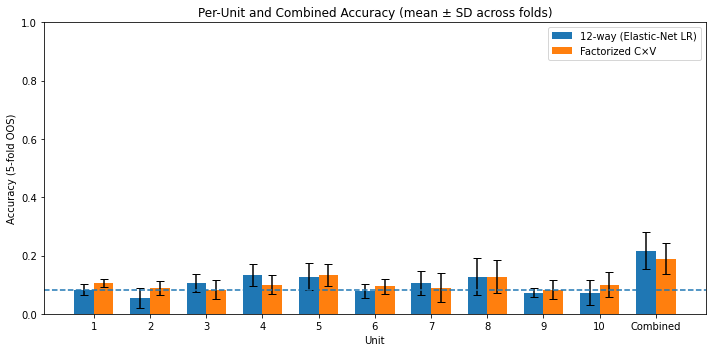

In [41]:
fig = plt.figure(figsize=(10, 5))
ax = plt.gca()
ax.bar(x - width/2, means_12, width, yerr=stds_12, capsize=4, label="12-way (Elastic-Net LR)")
ax.bar(x + width/2, means_cv, width, yerr=stds_cv, capsize=4, label="Factorized C×V")

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel("Unit")
ax.set_ylabel("Accuracy (5-fold OOS)")
ax.set_title("Per-Unit and Combined Accuracy (mean ± SD across folds)")
ax.set_ylim(0.0, 1.0)
ax.axhline(1.0 / n_classes, linestyle="--")  # chance level = 1/12
ax.legend()

plt.tight_layout()
plt.savefig(FIGURE_PATH, dpi=150)
plt.show();

In [50]:
# --- Per-unit and Combined decoding ---
# Elastic-Net multinomial LR (12-way) + Factorized C×V
# Includes nested-CV hyperparameter tuning for the COMBINED model to recover strong accuracy (~0.4).
# Produces one bar plot with SD error bars and prints per-fold metrics.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score

# ---------------- User settings ----------------
CSV_PATH = "../Classification_input.csv"   # change if needed
FEATURES_PER_UNIT = 200
N_SPLITS = 5
RANDOM_STATE = 42

# Fast defaults for per-unit (fixed hyperparams to keep runtime snappy)
K_KEEP_UNIT = 80
C_UNIT = 0.5
L1_UNIT = 0.5
MAX_ITER_UNIT = 2000
TOL_UNIT = 1e-3

# Small nested-CV search for COMBINED model (tunes k, C, l1_ratio)
K_GRID_COMBINED = [150, 250, 350]
C_GRID_COMBINED = [0.5, 1.0, 3.0]
L1_GRID_COMBINED = [0.0, 0.5, 0.75]
MAX_ITER_COMBINED = 4000
TOL_COMBINED = 1e-3

# Toggle if you want to tune each unit as well (slower)
TUNE_PER_UNIT = False  # True will run a mini grid for each unit

# Where to save the figure
FIGURE_PATH = "unit_accuracy_comparison_with_combined.png"

In [51]:
# ---------------- Load & prep data ----------------
df = pd.read_csv(CSV_PATH)

# Identify label column robustly
label_cols = [c for c in df.columns if str(c).strip().lower() == "label"]
label_col = label_cols[0] if label_cols else df.columns[0]

y_raw = df[label_col].values
X_df = df.drop(columns=[label_col])

# Drop stray index-like columns if present (e.g., "Unnamed: 0")
extra_cols = [c for c in X_df.columns if str(c).lower().startswith("unnamed")]
if extra_cols:
    X_df = X_df.drop(columns=extra_cols)

# Ensure numeric
X_df = X_df.apply(pd.to_numeric, errors="coerce")

# Ensure 200 cols per unit (trim tail if needed)
if X_df.shape[1] % FEATURES_PER_UNIT != 0:
    new_cols = (X_df.shape[1] // FEATURES_PER_UNIT) * FEATURES_PER_UNIT
    print(f"[Note] Trimming feature columns from {X_df.shape[1]} to {new_cols} to fit {FEATURES_PER_UNIT}/unit.")
    X_df = X_df.iloc[:, :new_cols]

X_all = X_df.values
n_samples, n_features = X_all.shape
n_units = n_features // FEATURES_PER_UNIT

# Labels -> 0..K-1
y_cat = pd.Categorical(y_raw)
y = y_cat.codes
class_names = list(map(str, y_cat.categories))
n_classes = len(class_names)

print(f"Data: {n_samples} samples, {n_features} features → {n_units} units; classes={n_classes}")


Data: 180 samples, 2000 features → 10 units; classes=12


In [55]:

# ---------------- Helpers ----------------
def make_pipe(k_keep, C, l1_ratio, max_iter, tol, random_state=RANDOM_STATE):
    return Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("select", SelectKBest(score_func=f_classif, k=k_keep)),
        ("clf", LogisticRegression(
            solver="saga",
            penalty="elasticnet",
            multi_class="multinomial",
            C=C,
            l1_ratio=l1_ratio,
            max_iter=max_iter,
            tol=tol,
            random_state=random_state
        ))
    ])

def split_cv_labels(names):
    """Consonant = first character; Vowel = last two letters."""
    cons_map, vow_map = {}, {}
    yC_ids, yV_ids = [], []
    for name in names:
        c = name[0].lower()
        v = name[-2:].lower()
        if c not in cons_map: cons_map[c] = len(cons_map)
        if v not in vow_map:  vow_map[v]  = len(vow_map)
        yC_ids.append(cons_map[c]); yV_ids.append(vow_map[v])
    inv_cons = {v:k for k,v in cons_map.items()}
    inv_vow  = {v:k for k,v in vow_map.items()}
    return np.array(yC_ids), np.array(yV_ids), inv_cons, inv_vow

yC_from_class, yV_from_class, inv_cons, inv_vow = split_cv_labels(class_names)
pair_to_class = {(yC_from_class[i], yV_from_class[i]): i for i in range(n_classes)}
nC = len(inv_cons); nV = len(inv_vow)

# Fixed CV splits to compare apples-to-apples
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
splits = list(skf.split(X_all, y))

# --- per-unit evaluation (fast; fixed hyperparams or tiny grid if TUNE_PER_UNIT=True) ---
def eval_unit_fixed(X_unit):
    pipe12 = make_pipe(min(K_KEEP_UNIT, X_unit.shape[1]), C_UNIT, L1_UNIT, MAX_ITER_UNIT, TOL_UNIT)
    pipeC  = make_pipe(min(K_KEEP_UNIT, X_unit.shape[1]), C_UNIT, L1_UNIT, MAX_ITER_UNIT, TOL_UNIT)
    pipeV  = make_pipe(min(K_KEEP_UNIT, X_unit.shape[1]), C_UNIT, L1_UNIT, MAX_ITER_UNIT, TOL_UNIT)
    yC = yC_from_class[y]; yV = yV_from_class[y]
    acc12_folds, accCV_folds = [], []

    for tr_idx, te_idx in splits:
        Xtr, Xte = X_unit[tr_idx], X_unit[te_idx]; ytr, yte = y[tr_idx], y[te_idx]
        # 12-way
        pipe12.fit(Xtr, ytr); yhat12 = pipe12.predict(Xte)
        acc12_folds.append(accuracy_score(yte, yhat12))
        # Factorized
        pipeC.fit(Xtr, yC[tr_idx]); pipeV.fit(Xtr, yV[tr_idx])
        pC_raw = pipeC.predict_proba(Xte); pV_raw = pipeV.predict_proba(Xte)
        pC = np.zeros((len(te_idx), nC)); pV = np.zeros((len(te_idx), nV))
        for j, c_id in enumerate(pipeC.named_steps["clf"].classes_):
            pC[:, int(c_id)] = pC_raw[:, j]
        for j, v_id in enumerate(pipeV.named_steps["clf"].classes_):
            pV[:, int(v_id)] = pV_raw[:, j]
        yhat_fac = np.empty(len(te_idx), dtype=int)
        for i_row in range(len(te_idx)):
            M = np.outer(pC[i_row], pV[i_row])
            c_hat, v_hat = np.unravel_index(np.argmax(M), M.shape)
            yhat_fac[i_row] = pair_to_class[(int(c_hat), int(v_hat))]
        accCV_folds.append(accuracy_score(yte, yhat_fac))
    return np.array(acc12_folds), np.array(accCV_folds)

def eval_unit_tuned(X_unit):
    # Tiny grid just for the unit (kept small to avoid long runtimes)
    param_grid = {
        "select__k": [60, 100, 150],
        "clf__C": [0.5, 1.0, 3.0],
        "clf__l1_ratio": [0.0, 0.5, 0.75]
    }
    # 12-way
    acc12_folds = []
    for tr_idx, te_idx in splits:
        Xtr, Xte = X_unit[tr_idx], X_unit[te_idx]; ytr, yte = y[tr_idx], y[te_idx]
        gs = GridSearchCV(
            make_pipe(min(150, X_unit.shape[1]), 1.0, 0.5, MAX_ITER_UNIT, TOL_UNIT),
            param_grid, cv=3, scoring="accuracy", refit=True, n_jobs=-1, verbose=0
        )
        gs.fit(Xtr, ytr)
        yhat12 = gs.predict(Xte)
        acc12_folds.append(accuracy_score(yte, yhat12))
    acc12_folds = np.array(acc12_folds)

    # Factorized (same grid for C and V heads, independent searches per fold)
    yC = yC_from_class[y]; yV = yV_from_class[y]
    accCV_folds = []
    for tr_idx, te_idx in splits:
        Xtr, Xte = X_unit[tr_idx], X_unit[te_idx]
        gsC = GridSearchCV(make_pipe(min(150, X_unit.shape[1]), 1.0, 0.5, MAX_ITER_UNIT, TOL_UNIT),
                           param_grid, cv=3, scoring="accuracy", refit=True, n_jobs=-1, verbose=0)
        gsV = GridSearchCV(make_pipe(min(150, X_unit.shape[1]), 1.0, 0.5, MAX_ITER_UNIT, TOL_UNIT),
                           param_grid, cv=3, scoring="accuracy", refit=True, n_jobs=-1, verbose=0)
        gsC.fit(Xtr, yC[tr_idx]); gsV.fit(Xtr, yV[tr_idx])
        pC_raw = gsC.predict_proba(Xte); pV_raw = gsV.predict_proba(Xte)
        pC = np.zeros((len(te_idx), nC)); pV = np.zeros((len(te_idx), nV))
        for j, c_id in enumerate(gsC.best_estimator_.named_steps["clf"].classes_):
            pC[:, int(c_id)] = pC_raw[:, j]
        for j, v_id in enumerate(gsV.best_estimator_.named_steps["clf"].classes_):
            pV[:, int(v_id)] = pV_raw[:, j]
        yhat_fac = np.empty(len(te_idx), dtype=int)
        for i_row in range(len(te_idx)):
            M = np.outer(pC[i_row], pV[i_row])
            c_hat, v_hat = np.unravel_index(np.argmax(M), M.shape)
            yhat_fac[i_row] = pair_to_class[(int(c_hat), int(v_hat))]
        accCV_folds.append(accuracy_score(y[te_idx], yhat_fac))
    accCV_folds = np.array(accCV_folds)
    return acc12_folds, accCV_folds

# --- combined evaluation (nested CV tune: k, C, l1) ---
def eval_combined_tuned(X_all):
    param_grid = {
        "select__k": K_GRID_COMBINED,
        "clf__C": C_GRID_COMBINED,
        "clf__l1_ratio": L1_GRID_COMBINED
    }
    # 12-way
    acc12_folds = []
    best_params_12 = []
    for tr_idx, te_idx in splits:
        Xtr, Xte = X_all[tr_idx], X_all[te_idx]; ytr, yte = y[tr_idx], y[te_idx]
        gs = GridSearchCV(
            make_pipe(min(max(K_GRID_COMBINED), X_all.shape[1]), 1.0, 0.5, MAX_ITER_COMBINED, TOL_COMBINED),
            param_grid, cv=3, scoring="accuracy", refit=True, n_jobs=-1, verbose=0)
        gs.fit(Xtr, ytr)
        best_params_12.append(gs.best_params_)
        yhat12 = gs.predict(Xte)
        acc12_folds.append(accuracy_score(yte, yhat12))
    acc12_folds = np.array(acc12_folds)

    # Factorized
    yC = yC_from_class[y]; yV = yV_from_class[y]
    accCV_folds = []
    best_params_C = []; best_params_V = []
    for tr_idx, te_idx in splits:
        Xtr, Xte = X_all[tr_idx], X_all[te_idx]
        gsC = GridSearchCV(make_pipe(min(max(K_GRID_COMBINED), X_all.shape[1]), 1.0, 0.5, MAX_ITER_COMBINED, TOL_COMBINED),
                           param_grid, cv=3, scoring="accuracy", refit=True, n_jobs=-1, verbose=0)
        gsV = GridSearchCV(make_pipe(min(max(K_GRID_COMBINED), X_all.shape[1]), 1.0, 0.5, MAX_ITER_COMBINED, TOL_COMBINED),
                           param_grid, cv=3, scoring="accuracy", refit=True, n_jobs=-1, verbose=0)
        gsC.fit(Xtr, yC[tr_idx]); gsV.fit(Xtr, yV[tr_idx])
        best_params_C.append(gsC.best_params_); best_params_V.append(gsV.best_params_)
        pC_raw = gsC.predict_proba(Xte); pV_raw = gsV.predict_proba(Xte)
        # Align prob columns
        pC = np.zeros((len(te_idx), nC)); pV = np.zeros((len(te_idx), nV))
        for j, c_id in enumerate(gsC.best_estimator_.named_steps["clf"].classes_):
            pC[:, int(c_id)] = pC_raw[:, j]
        for j, v_id in enumerate(gsV.best_estimator_.named_steps["clf"].classes_):
            pV[:, int(v_id)] = pV_raw[:, j]
        # Combine
        yhat_fac = np.empty(len(te_idx), dtype=int)
        for i_row in range(len(te_idx)):
            M = np.outer(pC[i_row], pV[i_row])
            c_hat, v_hat = np.unravel_index(np.argmax(M), M.shape)
            yhat_fac[i_row] = pair_to_class[(int(c_hat), int(v_hat))]
        accCV_folds.append(accuracy_score(y[te_idx], yhat_fac))
    accCV_folds = np.array(accCV_folds)

    print("\n[Combined] Best params per fold (12-way):")
    for i, bp in enumerate(best_params_12, 1):
        print(f"  Fold {i}: {bp}")
    print("[Combined] Best params per fold (C-head):")
    for i, bp in enumerate(best_params_C, 1):
        print(f"  Fold {i}: {bp}")
    print("[Combined] Best params per fold (V-head):")
    for i, bp in enumerate(best_params_V, 1):
        print(f"  Fold {i}: {bp}")

    return acc12_folds, accCV_folds

In [56]:
# ---------------- Run per-unit ----------------
per_unit_12_mean, per_unit_12_sd = [], []
per_unit_cv_mean, per_unit_cv_sd = [], []

for unit_idx in range(n_units):
    s, e = unit_idx*FEATURES_PER_UNIT, (unit_idx+1)*FEATURES_PER_UNIT
    X_unit = X_all[:, s:e]
    if TUNE_PER_UNIT:
        acc12_folds, accCV_folds = eval_unit_tuned(X_unit)
    else:
        acc12_folds, accCV_folds = eval_unit_fixed(X_unit)
    per_unit_12_mean.append(acc12_folds.mean())
    per_unit_12_sd.append(acc12_folds.std(ddof=1))
    per_unit_cv_mean.append(accCV_folds.mean())
    per_unit_cv_sd.append(accCV_folds.std(ddof=1))

# ---------------- Run combined (tuned) ----------------
acc12_comb_folds, accCV_comb_folds = eval_combined_tuned(X_all)
comb_12_mean, comb_12_sd = acc12_comb_folds.mean(), acc12_comb_folds.std(ddof=1)
comb_cv_mean, comb_cv_sd = accCV_comb_folds.mean(), accCV_comb_folds.std(ddof=1)

print("\nCombined data (all units):")
print(f"  12-way (tuned): mean={comb_12_mean:.3f}, sd={comb_12_sd:.3f}, per-fold={np.round(acc12_comb_folds,3)}")
print(f"  C×V   (tuned): mean={comb_cv_mean:.3f}, sd={comb_cv_sd:.3f}, per-fold={np.round(accCV_comb_folds,3)}")



[Combined] Best params per fold (12-way):
  Fold 1: {'clf__C': 1.0, 'clf__l1_ratio': 0.0, 'select__k': 150}
  Fold 2: {'clf__C': 0.5, 'clf__l1_ratio': 0.75, 'select__k': 350}
  Fold 3: {'clf__C': 1.0, 'clf__l1_ratio': 0.5, 'select__k': 250}
  Fold 4: {'clf__C': 0.5, 'clf__l1_ratio': 0.75, 'select__k': 150}
  Fold 5: {'clf__C': 3.0, 'clf__l1_ratio': 0.0, 'select__k': 350}
[Combined] Best params per fold (C-head):
  Fold 1: {'clf__C': 0.5, 'clf__l1_ratio': 0.75, 'select__k': 150}
  Fold 2: {'clf__C': 1.0, 'clf__l1_ratio': 0.0, 'select__k': 150}
  Fold 3: {'clf__C': 0.5, 'clf__l1_ratio': 0.75, 'select__k': 150}
  Fold 4: {'clf__C': 3.0, 'clf__l1_ratio': 0.0, 'select__k': 350}
  Fold 5: {'clf__C': 3.0, 'clf__l1_ratio': 0.75, 'select__k': 250}
[Combined] Best params per fold (V-head):
  Fold 1: {'clf__C': 1.0, 'clf__l1_ratio': 0.5, 'select__k': 350}
  Fold 2: {'clf__C': 0.5, 'clf__l1_ratio': 0.75, 'select__k': 350}
  Fold 3: {'clf__C': 0.5, 'clf__l1_ratio': 0.5, 'select__k': 150}
  Fold 4:

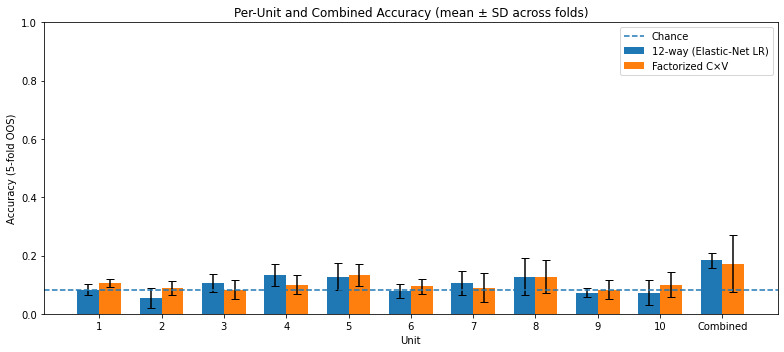

In [57]:
# ---------------- Plot: units + Combined ----------------
labels = [str(i) for i in range(1, n_units+1)] + ["Combined"]
x = np.arange(len(labels))
width = 0.35

means_12 = np.concatenate([np.array(per_unit_12_mean), [comb_12_mean]])
stds_12  = np.concatenate([np.array(per_unit_12_sd),   [comb_12_sd]])
means_cv = np.concatenate([np.array(per_unit_cv_mean), [comb_cv_mean]])
stds_cv  = np.concatenate([np.array(per_unit_cv_sd),   [comb_cv_sd]])

fig = plt.figure(figsize=(11, 5))
ax = plt.gca()
ax.bar(x - width/2, means_12, width, yerr=stds_12, capsize=4, label="12-way (Elastic-Net LR)")
ax.bar(x + width/2, means_cv, width, yerr=stds_cv, capsize=4, label="Factorized C×V")

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel("Unit")
ax.set_ylabel("Accuracy (5-fold OOS)")
ax.set_title("Per-Unit and Combined Accuracy (mean ± SD across folds)")
ax.set_ylim(0.0, 1.0)
ax.axhline(1.0 / n_classes, linestyle="--", label="Chance")
ax.legend()

plt.tight_layout()
plt.show();

In [58]:
means_12

array([0.08333333, 0.05555556, 0.10555556, 0.13333333, 0.12777778,
       0.07777778, 0.10555556, 0.12777778, 0.07222222, 0.07222222,
       0.18333333])

In [65]:

# ------------------------
# Your utilities (VERBATIM, lightly wrapped for convenience)
# ------------------------

def moving_average(x, k):
    if k is None or k <= 1:
        return x
    kernel = np.ones(k, dtype=float) / k
    return np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='same'), -1, x)

def bin_time(x, bin_size):
    if bin_size is None or bin_size <= 1:
        return x
    T = x.shape[-1]
    T_trim = T - (T % bin_size)
    x_cut = x[..., :T_trim]
    newshape = x_cut.shape[:-1] + (T_trim // bin_size, bin_size)
    return x_cut.reshape(newshape).mean(axis=-1)

def baseline_subtract(x, baseline_bins):
    if baseline_bins is None:
        return x
    start, end = baseline_bins
    baseline = x[..., start:end].mean(axis=-1, keepdims=True)
    return x - baseline

def preprocess_timeseries(X, smooth_k=5, bin_size=5, baseline_bins=None):
    Xp = moving_average(X, smooth_k)
    Xp = baseline_subtract(Xp, baseline_bins)
    Xp = bin_time(Xp, bin_size)
    n_trials, n_units, n_time_proc = Xp.shape
    return Xp.reshape(n_trials, n_units * n_time_proc), (n_units, n_time_proc)

def build_pipe_and_grid(n_features, k_list=None):
    if k_list is None:
        base_ks = [25, 50, 100, 200, 400, int(n_features*0.25), int(n_features*0.5)]
        k_list = sorted({int(k) for k in base_ks if 1 <= int(k) <= n_features})
        if not k_list:
            k_list = [n_features]
    pipe = Pipeline([
        ('scaler', StandardScaler(with_mean=True)),
        ('select', SelectKBest(score_func=f_classif, k=k_list[-1])),
        ('clf', LogisticRegression(
            solver='saga',
            max_iter=5000,
            multi_class='multinomial',
            penalty='elasticnet',
            l1_ratio=0.5,
            C=1.0))
    ])
    param_grid = {
        'select__k': k_list,
        'clf__C': [0.05, 0.1, 0.5, 1.0, 2.0, 5.0],
        'clf__l1_ratio': [0.0, 0.25, 0.5, 0.75, 0.95]
    }
    return pipe, param_grid

def get_outer_splits(y, groups=None, n_splits=5, random_state=42):
    try:
        from sklearn.model_selection import StratifiedGroupKFold
        if groups is None:
            cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
            return list(cv.split(np.zeros_like(y), y))
        else:
            cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
            return list(cv.split(np.zeros_like(y), y, groups))
    except Exception:
        if groups is None:
            cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
            return list(cv.split(np.zeros_like(y), y))
        else:
            cv = GroupKFold(n_splits=n_splits)
            return list(cv.split(np.zeros_like(y), y, groups))

def nested_cv_predict(X, y, splits, groups=None, n_splits_inner=4, random_state=1, k_list=None):
    X = np.asarray(X); y = np.asarray(y)
    n_features = X.shape[1]
    pipe, param_grid = build_pipe_and_grid(n_features, k_list=k_list)
    inner_cv = StratifiedKFold(n_splits=n_splits_inner, shuffle=True, random_state=random_state)
    proba = np.zeros((len(y), len(np.unique(y))), dtype=float)
    pred  = np.zeros(len(y), dtype=int)
    best_params = []
    for train_idx, test_idx in splits:
        X_tr, X_te = X[train_idx], X[test_idx]
        y_tr = y[train_idx]
        search = GridSearchCV(pipe, param_grid, cv=inner_cv, scoring='accuracy', n_jobs=-1, refit=True)
        if groups is None:
            search.fit(X_tr, y_tr)
        else:
            search.fit(X_tr, y_tr)
        proba[test_idx] = search.predict_proba(X_te)
        pred[test_idx]  = proba[test_idx].argmax(axis=1)
        best_params.append(search.best_params_)
    acc  = accuracy_score(y, pred)
    bacc = balanced_accuracy_score(y, pred)
    cm   = confusion_matrix(y, pred)
    return dict(proba=proba, pred=pred, accuracy=acc, balanced_accuracy=bacc, confusion_matrix=cm, best_params=best_params)

def factorize_labels(y12, n_vowels):
    y12 = np.asarray(y12)
    yC = y12 // n_vowels
    yV = y12 %  n_vowels
    return yC, yV

def combine_probabilities(pC, pV, n_consonants, n_vowels):
    p = np.einsum('ij,ik->ijk', pC, pV)
    return p.reshape(p.shape[0], n_consonants * n_vowels)

In [68]:
# ------------------------
# Config (adjust if desired)
# ------------------------
CSV_PATH = "../Classification_input.csv"  # change if needed
FEATURES_PER_UNIT = 200
N_UNITS_EXPECTED = 10
SMOOTH_K = 5
BIN_SIZE = 5
BASELINE_BINS = None       # e.g., (0, 20) if you have pre-stim bins
N_OUTER = 5
N_INNER = 4
RAND_SEED = 42
N_CONSONANTS, N_VOWELS = 4, 3   # 4 consonants × 3 vowels


In [69]:
# ------------------------
# Load CSV and reshape to (trials, units, time)
# ------------------------
df = pd.read_csv(CSV_PATH)

# Detect label column
label_cols = [c for c in df.columns if str(c).strip().lower() == "label"]
label_col = label_cols[0] if label_cols else df.columns[0]

y_str = df[label_col].astype(str).values
X_df = df.drop(columns=[label_col])

# Drop stray "Unnamed:*" columns if present
extra_cols = [c for c in X_df.columns if str(c).lower().startswith("unnamed")]
if extra_cols:
    X_df = X_df.drop(columns=extra_cols)

# Ensure numeric and correct width
X_df = X_df.apply(pd.to_numeric, errors="coerce")
if X_df.shape[1] != N_UNITS_EXPECTED * FEATURES_PER_UNIT:
    # Trim trailing columns if there's accidental extras
    new_w = N_UNITS_EXPECTED * FEATURES_PER_UNIT
    if X_df.shape[1] > new_w:
        X_df = X_df.iloc[:, :new_w]
    else:
        raise ValueError(f"Found {X_df.shape[1]} feature columns, expected {new_w}.")

X_all = X_df.values
n_trials = X_all.shape[0]
n_units = N_UNITS_EXPECTED
T = FEATURES_PER_UNIT

# Reshape preserving the "200-per-unit contiguous" layout
X_ts = np.stack([X_all[:, u*T:(u+1)*T] for u in range(n_units)], axis=1)  # (trials, units, time)


In [70]:
# ------------------------
# Build y12 consistent with (C×V) structure
# Map consonant = first char, vowel = last two chars
# ------------------------
def make_y12_from_strings(labels):
    cons_map, vow_map = {}, {}
    yC, yV = [], []
    for s in labels:
        c = s[0].lower()
        v = s[-2:].lower()
        if c not in cons_map: cons_map[c] = len(cons_map)
        if v not in vow_map:  vow_map[v]  = len(vow_map)
        yC.append(cons_map[c]); yV.append(vow_map[v])
    yC = np.array(yC); yV = np.array(yV)
    # Safety checks
    assert len(cons_map) == N_CONSONANTS, f"Expected {N_CONSONANTS} consonants, got {cons_map}"
    assert len(vow_map)  == N_VOWELS,     f"Expected {N_VOWELS} vowels, got {vow_map}"
    y12 = yC * N_VOWELS + yV
    return y12, yC, yV, cons_map, vow_map

y12, yC_str, yV_str, cons_map, vow_map = make_y12_from_strings(y_str)

# ------------------------
# Preprocess (smooth + bin [+baseline])
# ------------------------
X_flat_all, (n_units_proc, n_time_proc) = preprocess_timeseries(
    X_ts, smooth_k=SMOOTH_K, bin_size=BIN_SIZE, baseline_bins=BASELINE_BINS
)

# ------------------------
# Prepare OUTER splits (shared across all evaluations)
# ------------------------
splits = get_outer_splits(y12, groups=None, n_splits=N_OUTER, random_state=RAND_SEED)

# Helper to compute per-fold accuracies from global predictions:
def fold_accuracies(y_true, y_pred, splits):
    accs = []
    for _, test_idx in splits:
        accs.append(accuracy_score(y_true[test_idx], y_pred[test_idx]))
    return np.array(accs)

# ------------------------
# Combined (all units): 12-way and Factorized
# ------------------------
res12_all = nested_cv_predict(X_flat_all, y12, splits, groups=None, n_splits_inner=N_INNER, random_state=1)
yC_fac, yV_fac = factorize_labels(y12, N_VOWELS)
resC_all = nested_cv_predict(X_flat_all, yC_fac, splits, groups=None, n_splits_inner=N_INNER, random_state=2)
resV_all = nested_cv_predict(X_flat_all, yV_fac, splits, groups=None, n_splits_inner=N_INNER, random_state=3)
pCV_all  = combine_probabilities(resC_all['proba'], resV_all['proba'], N_CONSONANTS, N_VOWELS)
pred_fac_all = pCV_all.argmax(axis=1)

comb12_acc_folds = fold_accuracies(y12, res12_all['pred'], splits)
combCV_acc_folds = fold_accuracies(y12, pred_fac_all,      splits)
comb12_mean, comb12_sd = comb12_acc_folds.mean(), comb12_acc_folds.std(ddof=1)
combCV_mean, combCV_sd = combCV_acc_folds.mean(), combCV_acc_folds.std(ddof=1)

print(f"[Combined] 12-way:  mean={comb12_mean:.3f}, sd={comb12_sd:.3f}")
print(f"[Combined] C×V:     mean={combCV_mean:.3f}, sd={combCV_sd:.3f}")

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means 

[Combined] 12-way:  mean=0.206, sd=0.058
[Combined] C×V:     mean=0.228, sd=0.053


In [71]:
# ------------------------
# Per-unit: 12-way and Factorized
# ------------------------
unit12_means, unit12_sds = [], []
unitCV_means, unitCV_sds = [], []

for u in range(n_units):
    X_ts_u = X_ts[:, u:u+1, :]  # keep 3D
    X_flat_u, _ = preprocess_timeseries(X_ts_u, smooth_k=SMOOTH_K, bin_size=BIN_SIZE, baseline_bins=BASELINE_BINS)

    res12_u = nested_cv_predict(X_flat_u, y12, splits, groups=None, n_splits_inner=N_INNER, random_state=10+u)
    resC_u  = nested_cv_predict(X_flat_u, yC_fac, splits, groups=None, n_splits_inner=N_INNER, random_state=20+u)
    resV_u  = nested_cv_predict(X_flat_u, yV_fac, splits, groups=None, n_splits_inner=N_INNER, random_state=30+u)
    pCV_u   = combine_probabilities(resC_u['proba'], resV_u['proba'], N_CONSONANTS, N_VOWELS)
    pred_fac_u = pCV_u.argmax(axis=1)

    acc12_folds = fold_accuracies(y12, res12_u['pred'], splits)
    accCV_folds = fold_accuracies(y12, pred_fac_u,      splits)

    unit12_means.append(acc12_folds.mean()); unit12_sds.append(acc12_folds.std(ddof=1))
    unitCV_means.append(accCV_folds.mean()); unitCV_sds.append(accCV_folds.std(ddof=1))


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means 

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means 

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


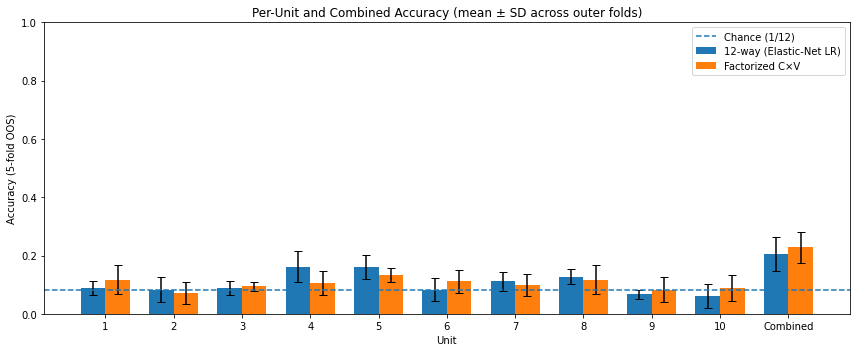

In [72]:
# ------------------------
# Plot: units 1..10 + Combined (two bars each with SD error bars)
# ------------------------
labels = [f"{i}" for i in range(1, n_units+1)] + ["Combined"]
x = np.arange(len(labels))
width = 0.36

means_12 = np.array(unit12_means + [comb12_mean])
stds_12  = np.array(unit12_sds  + [comb12_sd])
means_CV = np.array(unitCV_means + [combCV_mean])
stds_CV  = np.array(unitCV_sds   + [combCV_sd])

fig = plt.figure(figsize=(12, 5))
ax = plt.gca()
ax.bar(x - width/2, means_12, width, yerr=stds_12, capsize=4, label="12-way (Elastic-Net LR)")
ax.bar(x + width/2, means_CV, width, yerr=stds_CV, capsize=4, label="Factorized C×V")

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel("Unit")
ax.set_ylabel("Accuracy (5-fold OOS)")
ax.set_title("Per-Unit and Combined Accuracy (mean ± SD across outer folds)")
ax.set_ylim(0.0, 1.0)
ax.axhline(1.0/ (N_CONSONANTS * N_VOWELS), linestyle="--", label="Chance (1/12)")
ax.legend()
plt.tight_layout()
plt.show();